# Phase 5 Lesson Notebook: Deep Forecasting with LSTM and TCN

What we are doing in this notebook is building an end-to-end, fully explained deep-learning forecasting pipeline.

We start from engineered data (Phase 2 outputs), construct sequential samples, train two sequence models (LSTM and TCN), tune hyperparameters and interpret results.

## 1) Imports, Reproducibility, and Device Setup

What we are doing here is preparing the runtime environment so experiments are repeatable and efficient.

- We import all required libraries.
- We fix random seeds.
- We choose the best available device (MPS, CUDA, or CPU).

In [19]:
import json
import random
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import optuna
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Torch version:', torch.__version__)
print('Using device:', DEVICE)

Torch version: 2.10.0
Using device: mps


## 2) Configuration

What we are doing in this section is defining all key experiment settings in one place.

- Increase seq_len when longer seasonal memory seems important.
- Increase hidden_size/layers when underfitting is visible.
- Increase dropout when overfitting appears.
- Reduce trials/epochs for faster iteration; raise them for stronger final quality.
- Tune rmspe_alpha upward if competition-style percentage error is your top objective.

Keeping these settings centralized makes iteration and debugging much easier.

In [ ]:
@dataclass
class Config:
    # ------------------------------------------------------------
    # BASELINE FORECAST TASK DEFINITION
    # ------------------------------------------------------------
    # horizon: number of future days predicted at once (multi-step forecasting).
    # Example: horizon=7 means the model outputs t+1 ... t+7 in one pass.
    horizon: int = 7

    # seq_len: number of historical days provided as model input window.
    # Example: seq_len=28 gives 4 weeks of context for each training sample.
    seq_len: int = 28

    # batch_size: number of sequences per optimization step.
    # Larger batches -> smoother gradients, higher memory use.
    batch_size: int = 256

    # ------------------------------------------------------------
    # TRAINING + TUNING BUDGET (RUNTIME CONTROL)
    # ------------------------------------------------------------
    # epochs: full training passes used for final model fitting.
    epochs: int = 25

    # optuna_trials: number of hyperparameter configurations to test.
    # Increasing this improves search coverage but increases runtime.
    optuna_trials: int = 10

    # optuna_epochs: short training schedule per trial for affordable search.
    # Keep this lower than final epochs to make tuning practical.
    optuna_epochs: int = 3

    # ------------------------------------------------------------
    # BASE MODEL DEFAULTS (STARTING POINT BEFORE TUNING)
    # ------------------------------------------------------------
    # lr: default optimizer learning rate.
    # Too high can diverge; too low can under-train.
    lr: float = 1e-3

    # hidden_size: latent representation width for sequence encoders.
    # Higher values increase capacity and compute/memory usage.
    hidden_size: int = 64

    # lstm_layers: recurrent depth for the LSTM variant.
    # Ignored by TCN, but kept here for one unified config object.
    lstm_layers: int = 2

    # dropout: regularization strength inside model blocks.
    # Helps reduce overfitting by randomly dropping activations during training.
    dropout: float = 0.1

    # ------------------------------------------------------------
    # DATA-SCOPE CONTROL (OPTIONAL FAST EXPERIMENT MODE)
    # ------------------------------------------------------------
    # max_stores:
    #   - None  -> use all stores (full dataset).
    #   - int N -> keep top-N stores by sample count.
    # Useful when debugging quickly on limited hardware.
    max_stores: int | None = None

    # ------------------------------------------------------------
    # PROBABILISTIC FORECASTING SETUP
    # ------------------------------------------------------------
    # quantiles: prediction levels for uncertainty intervals.
    # (0.1, 0.5, 0.9) corresponds to p10 / median / p90 outputs.
    quantiles: tuple = (0.1, 0.5, 0.9)

    # ------------------------------------------------------------
    # RMSPE-ORIENTED TRAINING CONTROLS
    # ------------------------------------------------------------
    # log_target: if True, train on log1p(Sales) then invert for metrics.
    # Can stabilize training when target is heavy-tailed.
    log_target: bool = False

    # rmspe_alpha: weight of RMSPE-style proxy term in total loss.
    # Larger values prioritize percentage-error behavior more strongly.
    rmspe_alpha: float = 0.12

    # ------------------------------------------------------------
    # METRIC LOGGING CONTROL (FAIR TRAIN vs VAL CURVES)
    # ------------------------------------------------------------
    # metric_eval_train_batches: evaluate train metrics in eval mode on only
    # a fixed number of deterministic batches each epoch.
    # This keeps curves comparable to validation without full-train overhead.
    metric_eval_train_batches: int = 120


CFG = Config()
CFG

Config(horizon=7, seq_len=28, batch_size=256, epochs=16, optuna_trials=10, optuna_epochs=2, lr=0.001, hidden_size=64, lstm_layers=2, dropout=0.1, max_stores=None, quantiles=(0.1, 0.5, 0.9), log_target=False, rmspe_alpha=0.12, metric_eval_train_batches=120)

## 3) Load Phase 2 Data

What we are doing next is loading the prepared Phase 2 splits directly.

In [21]:
base = Path('../data/phase2_output/pkl')
train_df = pd.read_pickle(base / 'train_split.pkl')
val_df = pd.read_pickle(base / 'val_split.pkl')
test_df = pd.read_pickle(base / 'test_split.pkl')
scaler = pd.read_pickle(base / 'robust_scaler.pkl')

for frame in (train_df, val_df, test_df):
    frame['Date'] = pd.to_datetime(frame['Date'])

# Keep strict date order per store for sequence creation.
train_df = train_df.sort_values(['Store', 'Date']).reset_index(drop=True)
val_df = val_df.sort_values(['Store', 'Date']).reset_index(drop=True)
test_df = test_df.sort_values(['Store', 'Date']).reset_index(drop=True)

print('Train:', train_df.shape)
print('Val  :', val_df.shape)
print('Test :', test_df.shape)

# Quick sanity checks for soundness
for name, frame in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    has_null_sales = frame['Sales'].isna().any()
    date_min = frame['Date'].min()
    date_max = frame['Date'].max()
    print(f"{name} date range: {date_min.date()} -> {date_max.date()} | Sales NA: {has_null_sales}")

Train: (794209, 157)
Val  : (103695, 157)
Test : (103695, 157)
Train date range: 2013-01-01 -> 2015-01-12 | Sales NA: False
Val date range: 2015-01-13 -> 2015-04-15 | Sales NA: False
Test date range: 2015-04-16 -> 2015-07-17 | Sales NA: False


In [22]:
print('Sales scale sanity:')
for name, frame in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"{name}: min={frame['Sales'].min():.2f}, median={frame['Sales'].median():.2f}, max={frame['Sales'].max():.2f}")

# One quick sequence-level target check after split build happens later:
print('Expected retail scale should be in the thousands for non-zero days.')

Sales scale sanity:
Train: min=0.00, median=5693.00, max=38037.00
Val: min=0.00, median=5844.00, max=38722.00
Test: min=0.00, median=6007.00, max=41551.00
Expected retail scale should be in the thousands for non-zero days.


### Analysis: Data-Scale Sanity Check

Before training deep models, we verify that `Sales` is on its natural scale (thousands), not accidentally normalized.

If this check fails, all downstream error metrics become misleading (for example RMSE near 1 would indicate scaled target leakage).

## 4) Build the Modeling Feature Space

What we are doing is choosing model inputs in a principled way.

Instead of manually hand-picking a small list, we keep all numeric engineered and enriched features except strict exclusions (identifiers and target).

We explicitly exclude identifier-like columns (`Id`, `IdRaw`, `Store`, `StoreRaw`) so models do not learn spurious ordinal shortcuts.

In [23]:
# =========================
# Feature Selection
# =========================
# We keep all numeric engineered features except strict exclusions.
# Important: we exclude identifier-like columns to avoid ordinal-ID shortcuts
# that can dominate interpretation and harm generalization.

target_col = 'Sales'
exclude_cols = ['Date', 'Id', 'IdRaw', target_col, 'StoreRaw', 'Store']

candidate_features = [
    c for c in train_df.columns
    if c not in exclude_cols and np.issubdtype(train_df[c].dtype, np.number)
]

# Store filtering logic (transparent and optional)
if CFG.max_stores is None:
    selected_stores = set(train_df['Store'].unique())
else:
    store_counts = train_df['Store'].value_counts().sort_values(ascending=False)
    selected_stores = set(store_counts.head(CFG.max_stores).index)

train_df = train_df[train_df['Store'].isin(selected_stores)].copy()
val_df = val_df[val_df['Store'].isin(selected_stores)].copy()
test_df = test_df[test_df['Store'].isin(selected_stores)].copy()

print('Feature count:', len(candidate_features))
print('Selected stores:', len(selected_stores))
print('Filtered train shape:', train_df.shape)
print('Sample candidate features:', candidate_features[:12])

Feature count: 132
Selected stores: 1115
Filtered train shape: (794209, 157)
Sample candidate features: ['DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'is_promo2']


## 5) Convert Tabular Data into Sequential Supervised Samples

What we are doing is transforming each store timeline into sliding windows suitable for sequence models.

Input window length: `seq_len`
Prediction horizon: `horizon`

This is the key step that reframes forecasting into supervised learning for deep networks.

In [24]:
class SequenceDataset(Dataset):
    """
    Builds supervised sequence samples per store.
    Each sample:
      X: [seq_len, n_features]
      y: [horizon]

    If log_target=True, y is transformed by log1p for more stable percentage-error learning.
    """
    def __init__(self, df, feature_cols, target_col, seq_len=28, horizon=7, log_target=False):
        self.X = []
        self.y = []

        for _, g in df.groupby('Store'):
            g = g.sort_values('Date')
            feat = g[feature_cols].values.astype(np.float32)
            targ = g[target_col].values.astype(np.float32)
            if log_target:
                targ = np.log1p(np.clip(targ, a_min=0, a_max=None))

            n = len(g)
            end_limit = n - seq_len - horizon + 1
            if end_limit <= 0:
                continue

            for start in range(end_limit):
                x_slice = feat[start:start + seq_len]
                y_slice = targ[start + seq_len:start + seq_len + horizon]
                self.X.append(x_slice)
                self.y.append(y_slice)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = SequenceDataset(train_df, candidate_features, target_col, CFG.seq_len, CFG.horizon, log_target=CFG.log_target)
val_ds = SequenceDataset(val_df, candidate_features, target_col, CFG.seq_len, CFG.horizon, log_target=CFG.log_target)
test_ds = SequenceDataset(test_df, candidate_features, target_col, CFG.seq_len, CFG.horizon, log_target=CFG.log_target)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False)

print('Train sequences:', len(train_ds))
print('Val sequences  :', len(val_ds))
print('Test sequences :', len(test_ds))

Train sequences: 756299
Val sequences  : 65785
Test sequences : 65785


## 6) Define LSTM and TCN Models

What we are doing is implementing two complementary architectures:
- LSTM for recurrent sequence modeling,
- TCN for temporal convolutional modeling.

Both models output multiple quantiles so we can evaluate both point accuracy and predictive uncertainty.

In [ ]:
class LSTMQuantile(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, horizon, n_quantiles):
        super().__init__()
        self.horizon = horizon
        self.n_quantiles = n_quantiles
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Linear(hidden_size, horizon * n_quantiles)

    # The forward pass processes the input sequence through the LSTM and then applies
    # a linear head to the last hidden state to produce quantile predictions for the entire horizon.
    def forward(self, x):
        # x: [B, T, F], B: batch size, T: sequence length, F: feature count
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        pred = self.head(last)
        return pred.view(-1, self.horizon, self.n_quantiles) # reshape to [B, horizon, n_quantiles]


class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.1):
        super().__init__()
        pad = (kernel_size - 1) * dilation

        # weight normalization improves optimization stability for deep/dilated conv stacks.
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(in_ch, out_ch, kernel_size, padding=pad, dilation=dilation)
        )
        # GroupNorm (1 group = channel-wise layer norm style) reduces train-curve jitter.
        self.norm1 = nn.GroupNorm(num_groups=1, num_channels=out_ch)

        # apply the same stabilized conv+norm pattern in the second conv of the residual block.
        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(out_ch, out_ch, kernel_size, padding=pad, dilation=dilation)
        )
        self.norm2 = nn.GroupNorm(num_groups=1, num_channels=out_ch)

        # GELU is smoother than ReLU and often gives less noisy updates in TCNs.
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        residual = self.down(x)

        y = self.conv1(x)
        y = y[:, :, :x.size(-1)]  # causal trim
        y = self.norm1(y)
        y = self.act(y)
        y = self.drop(y)

        y = self.conv2(y)
        y = y[:, :, :x.size(-1)]  # causal trim
        y = self.norm2(y)
        y = self.act(y)
        y = self.drop(y)

        return y + residual


class TCNQuantile(nn.Module):
    def __init__(self, input_size, hidden_size, horizon, n_quantiles, dropout=0.1):
        super().__init__()
        self.horizon = horizon
        self.n_quantiles = n_quantiles

        self.block1 = TCNBlock(input_size, hidden_size, dilation=1, dropout=dropout)
        self.block2 = TCNBlock(hidden_size, hidden_size, dilation=2, dropout=dropout)
        self.block3 = TCNBlock(hidden_size, hidden_size, dilation=4, dropout=dropout)
        self.block4 = TCNBlock(hidden_size, hidden_size, dilation=8, dropout=dropout)
        self.head = nn.Linear(hidden_size, horizon * n_quantiles)

    def forward(self, x):
        # x: [B, T, F] -> [B, F, T], B: batch size, T: sequence length, F: feature count
        x = x.transpose(1, 2)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        last = x[:, :, -1]
        pred = self.head(last)
        return pred.view(-1, self.horizon, self.n_quantiles) # reshape to [B, horizon, n_quantiles]

## 7) Loss Design, Evaluation Metrics, and Training Utilities

What we are doing is defining a training objective that combines:
- quantile loss for calibrated uncertainty,
- RMSPE-oriented proxy term for competition-aligned error behavior.

We also compute multiple evaluation metrics to avoid misleading conclusions from any single score.

In [ ]:
QUANTILES = torch.tensor(CFG.quantiles, dtype=torch.float32, device=DEVICE)

def quantile_loss(pred_q, y_true, quantiles=QUANTILES):
    # Pinball/quantile loss over all horizons and quantiles.
    # pred_q: [B, H, Q], y_true: [B, H] B: batch size, H: horizon, Q: quantiles
    y = y_true.unsqueeze(-1)
    e = y - pred_q
    q = quantiles.view(1, 1, -1)
    return torch.maximum(q * e, (q - 1) * e).mean()


def rmspe_np(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true > 0
    if mask.sum() == 0:
        return np.nan
    pct = (y_true[mask] - y_pred[mask]) / np.maximum(y_true[mask], eps)
    return float(np.sqrt(np.mean(pct ** 2)))


def evaluate_regression(y_true, y_pred):
    # Aggregate point-forecast metrics (flattened over batch and horizon).
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    abs_err = np.abs(y_true - y_pred)
    mae = np.mean(abs_err)

    pos_mask = y_true > 0
    if np.any(pos_mask):
        mape_pos = mean_absolute_percentage_error(y_true[pos_mask], y_pred[pos_mask])
    else:
        mape_pos = np.nan

    wmape = abs_err.sum() / (np.abs(y_true).sum() + 1e-6)
    smape = np.mean(2.0 * abs_err / (np.abs(y_true) + np.abs(y_pred) + 1e-6))
    rmspe = rmspe_np(y_true, y_pred)

    r2 = r2_score(y_true, y_pred)
    return {
        'RMSE': float(rmse),
        'MAE': float(mae),
        'MAPE_pos': float(mape_pos) if not np.isnan(mape_pos) else np.nan,
        'WMAPE': float(wmape),
        'SMAPE': float(smape),
        'RMSPE': float(rmspe) if not np.isnan(rmspe) else np.nan,
        'R2': float(r2),
    }


def run_epoch(model, loader, optimizer=None, max_batches=None, grad_clip=None):
    # grad_clip argument lets us cap gradient norm during training for stability.
    # train_mode=True: optimization pass (dropout active, gradients enabled).
    # train_mode=False: pure evaluation pass (dropout inactive, no optimizer step).
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    losses = []
    all_y = []
    all_p50 = []
    all_q10 = []
    all_q90 = []

    with torch.set_grad_enabled(train_mode):
        for batch_idx, (xb, yb) in enumerate(loader):
            if max_batches is not None and batch_idx >= max_batches:
                break

            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pred = model(xb)
            q_loss = quantile_loss(pred, yb)

            # Use median quantile (p50) for point-metric computation.
            p50 = pred[:, :, 1]
            if CFG.log_target:
                y_real = torch.expm1(yb)
                p50_real = torch.expm1(p50)
            else:
                y_real = yb
                p50_real = p50

            p50_real = torch.clamp(p50_real, min=0.0)
            rmspe_proxy = torch.sqrt(
                torch.mean(((y_real - p50_real) / torch.clamp(y_real, min=1.0)) ** 2)
            )
            loss = q_loss + CFG.rmspe_alpha * rmspe_proxy

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                # gradient clipping prevents occasional exploding updates in TCN training.
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
                optimizer.step()

            losses.append(loss.item())
            all_y.append(yb.detach().cpu().numpy())
            all_q10.append(pred[:, :, 0].detach().cpu().numpy())
            all_p50.append(pred[:, :, 1].detach().cpu().numpy())
            all_q90.append(pred[:, :, 2].detach().cpu().numpy())

    y = np.concatenate(all_y, axis=0)
    p50 = np.concatenate(all_p50, axis=0)
    q10 = np.concatenate(all_q10, axis=0)
    q90 = np.concatenate(all_q90, axis=0)

    # Convert back to natural target scale if log-target training is active.
    if CFG.log_target:
        y_eval = np.expm1(y)
        p50_eval = np.expm1(p50)
        q10_eval = np.expm1(q10)
        q90_eval = np.expm1(q90)
    else:
        y_eval = y
        p50_eval = p50
        q10_eval = q10
        q90_eval = q90

    p50_eval = np.clip(p50_eval, a_min=0.0, a_max=None)
    q10_eval = np.clip(q10_eval, a_min=0.0, a_max=None)
    q90_eval = np.clip(q90_eval, a_min=0.0, a_max=None)

    metrics = evaluate_regression(y_eval.ravel(), p50_eval.ravel())

    coverage = np.mean((y_eval >= q10_eval) & (y_eval <= q90_eval))
    interval_width = np.mean(q90_eval - q10_eval)

    metrics['Coverage_q10_q90'] = float(coverage)
    metrics['MeanIntervalWidth'] = float(interval_width)
    metrics['Loss'] = float(np.mean(losses))

    horizon_rmse = []
    for h in range(y_eval.shape[1]):
        h_rmse = np.sqrt(mean_squared_error(y_eval[:, h], p50_eval[:, h]))
        horizon_rmse.append(h_rmse)
    metrics['RMSE_per_horizon'] = [float(v) for v in horizon_rmse]

    return metrics, y_eval, p50_eval, q10_eval, q90_eval


def fit_model(model, train_loader, val_loader, epochs, lr):
    # Adam + light weight decay for smoother generalization.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # lower LR automatically when validation RMSPE plateaus.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5
    )

    # Deterministic train-eval loader (no shuffle) for comparable train/validation curves.
    # We intentionally evaluate only a fixed number of batches for runtime balance.
    train_eval_loader = DataLoader(
        train_loader.dataset,
        batch_size=train_loader.batch_size,
        shuffle=False,
    )

    history = []
    best_state = None
    best_val_rmspe = np.inf

    for ep in range(1, epochs + 1):
        # 1) Optimization pass on shuffled train batches (actual learning step).
        train_opt_metrics, *_ = run_epoch(
            model,
            train_loader,
            optimizer=optimizer,
            grad_clip=1.0, 
        )

        # 2) Comparable train metric pass in eval mode on deterministic batches.
        train_metrics, *_ = run_epoch(
            model,
            train_eval_loader,
            optimizer=None,
            max_batches=CFG.metric_eval_train_batches,
        )

        # 3) Validation metric pass in eval mode.
        val_metrics, *_ = run_epoch(model, val_loader, optimizer=None)

        # scheduler uses validation RMSPE as control signal.
        scheduler.step(val_metrics['RMSPE'])

        row = {
            'epoch': ep,
            'lr': float(optimizer.param_groups[0]['lr']),  # log LR for curve diagnostics.
            **{f'train_{k}': v for k, v in train_metrics.items()},
            **{f'val_{k}': v for k, v in val_metrics.items()},
            **{f'train_opt_{k}': v for k, v in train_opt_metrics.items()},
        }
        history.append(row)

        if val_metrics['RMSPE'] < best_val_rmspe:
            best_val_rmspe = val_metrics['RMSPE']
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {ep:02d} | lr={optimizer.param_groups[0]['lr']:.6f} | "
            f"train(eval) RMSPE={train_metrics['RMSPE']:.4f} | "
            f"val RMSPE={val_metrics['RMSPE']:.4f} | val RMSE={val_metrics['RMSE']:.2f} | "
            f"val coverage={val_metrics['Coverage_q10_q90']:.3f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    return pd.DataFrame(history), float(best_val_rmspe)

## 8) Hyperparameter Tuning with Optuna

What we are doing is searching model hyperparameters under a fixed trial budget.

The objective is validation RMSPE, so the tuner optimizes directly for competition-style behavior.

After tuning, we will also visualize trial histories to see whether search is stable or noisy.

In [ ]:
input_size = len(candidate_features)
n_quant = len(CFG.quantiles)


def optuna_objective_factory(model_type):
    def objective(trial):
        hidden = trial.suggest_categorical('hidden_size', [32, 64, 96, 128])
        dropout = trial.suggest_float('dropout', 0.0, 0.35)

        if model_type == 'lstm':
            lr = trial.suggest_float('lr', 3e-4, 3e-3, log=True)
            layers = trial.suggest_int('lstm_layers', 1, 3)
            model = LSTMQuantile(input_size, hidden, layers, dropout, CFG.horizon, n_quant).to(DEVICE)
            trial_epochs = CFG.optuna_epochs
        else:
            lr = trial.suggest_float('lr', 1e-4, 1.5e-3, log=True)
            model = TCNQuantile(input_size, hidden, CFG.horizon, n_quant, dropout=dropout).to(DEVICE)
            trial_epochs = CFG.optuna_epochs

        _, best_rmspe = fit_model(
            model,
            train_loader,
            val_loader,
            epochs=trial_epochs,
            lr=lr,
        )
        return best_rmspe

    return objective


study_lstm = optuna.create_study(direction='minimize', study_name='lstm_phase5_rmspe')
study_lstm.optimize(optuna_objective_factory('lstm'), n_trials=CFG.optuna_trials)

study_tcn = optuna.create_study(direction='minimize', study_name='tcn_phase5_rmspe')
study_tcn.optimize(optuna_objective_factory('tcn'), n_trials=CFG.optuna_trials)

print('Best LSTM params:', study_lstm.best_params)
print('Best LSTM RMSPE:', study_lstm.best_value)
print('Best TCN params :', study_tcn.best_params)
print('Best TCN RMSPE :', study_tcn.best_value)

[I 2026-02-21 23:55:46,834] A new study created in memory with name: lstm_phase5_rmspe


Epoch 01 | lr=0.000313 | train(eval) RMSPE=0.9794 | val RMSPE=0.9796 | val RMSE=6857.28 | val coverage=0.100


[I 2026-02-21 23:57:53,916] Trial 0 finished with value: 0.9600022435188293 and parameters: {'hidden_size': 128, 'dropout': 0.0026866206315983854, 'lr': 0.0003130266631767898, 'lstm_layers': 3}. Best is trial 0 with value: 0.9600022435188293.


Epoch 02 | lr=0.000313 | train(eval) RMSPE=0.9596 | val RMSPE=0.9600 | val RMSE=6761.63 | val coverage=0.024
Epoch 01 | lr=0.002971 | train(eval) RMSPE=0.9520 | val RMSPE=0.9525 | val RMSE=6725.15 | val coverage=0.124


[I 2026-02-21 23:58:53,508] Trial 1 finished with value: 0.9057063460350037 and parameters: {'hidden_size': 32, 'dropout': 0.27347831225176583, 'lr': 0.0029714995127780616, 'lstm_layers': 2}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.002971 | train(eval) RMSPE=0.9046 | val RMSPE=0.9057 | val RMSE=6497.41 | val coverage=0.050
Epoch 01 | lr=0.000376 | train(eval) RMSPE=0.9938 | val RMSPE=0.9939 | val RMSE=6927.14 | val coverage=0.028


[I 2026-02-21 23:59:47,960] Trial 2 finished with value: 0.9878220558166504 and parameters: {'hidden_size': 32, 'dropout': 0.006475023810264963, 'lr': 0.00037626584467069486, 'lstm_layers': 1}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.000376 | train(eval) RMSPE=0.9877 | val RMSPE=0.9878 | val RMSE=6897.56 | val coverage=0.072
Epoch 01 | lr=0.000313 | train(eval) RMSPE=0.9800 | val RMSPE=0.9802 | val RMSE=6860.24 | val coverage=0.100


[I 2026-02-22 00:01:22,226] Trial 3 finished with value: 0.9606323838233948 and parameters: {'hidden_size': 128, 'dropout': 0.1852263667419891, 'lr': 0.00031310284147739937, 'lstm_layers': 2}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.000313 | train(eval) RMSPE=0.9602 | val RMSPE=0.9606 | val RMSE=6764.72 | val coverage=0.100
Epoch 01 | lr=0.000382 | train(eval) RMSPE=0.9877 | val RMSPE=0.9878 | val RMSE=6897.43 | val coverage=0.147


[I 2026-02-22 00:02:29,967] Trial 4 finished with value: 0.975747287273407 and parameters: {'hidden_size': 64, 'dropout': 0.01569369126758247, 'lr': 0.0003815013021674876, 'lstm_layers': 2}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.000382 | train(eval) RMSPE=0.9755 | val RMSPE=0.9757 | val RMSE=6838.64 | val coverage=0.048
Epoch 01 | lr=0.001766 | train(eval) RMSPE=0.9712 | val RMSPE=0.9715 | val RMSE=6818.34 | val coverage=0.076


[I 2026-02-22 00:03:22,553] Trial 5 finished with value: 0.9435511827468872 and parameters: {'hidden_size': 32, 'dropout': 0.10165283709725977, 'lr': 0.001766179497713393, 'lstm_layers': 1}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.001766 | train(eval) RMSPE=0.9428 | val RMSPE=0.9436 | val RMSE=6683.32 | val coverage=0.074
Epoch 01 | lr=0.000367 | train(eval) RMSPE=0.9824 | val RMSPE=0.9825 | val RMSE=6871.67 | val coverage=0.074


[I 2026-02-22 00:04:39,484] Trial 6 finished with value: 0.9652634263038635 and parameters: {'hidden_size': 96, 'dropout': 0.30183636272366193, 'lr': 0.00036746702760536717, 'lstm_layers': 2}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.000367 | train(eval) RMSPE=0.9649 | val RMSPE=0.9653 | val RMSE=6787.32 | val coverage=0.079
Epoch 01 | lr=0.000467 | train(eval) RMSPE=0.9847 | val RMSPE=0.9849 | val RMSE=6883.06 | val coverage=0.074


[I 2026-02-22 00:05:36,569] Trial 7 finished with value: 0.9701569080352783 and parameters: {'hidden_size': 64, 'dropout': 0.1622744661772435, 'lr': 0.00046687510322565763, 'lstm_layers': 1}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.000467 | train(eval) RMSPE=0.9699 | val RMSPE=0.9702 | val RMSE=6811.39 | val coverage=0.100
Epoch 01 | lr=0.000648 | train(eval) RMSPE=0.9894 | val RMSPE=0.9895 | val RMSE=6905.81 | val coverage=0.075


[I 2026-02-22 00:06:36,413] Trial 8 finished with value: 0.9790761470794678 and parameters: {'hidden_size': 32, 'dropout': 0.004800801570607754, 'lr': 0.000647817324689447, 'lstm_layers': 2}. Best is trial 1 with value: 0.9057063460350037.


Epoch 02 | lr=0.000648 | train(eval) RMSPE=0.9789 | val RMSPE=0.9791 | val RMSE=6855.05 | val coverage=0.027
Epoch 01 | lr=0.001200 | train(eval) RMSPE=0.9614 | val RMSPE=0.9619 | val RMSE=6771.49 | val coverage=0.100


[I 2026-02-22 00:07:33,179] Trial 9 finished with value: 0.9246213436126709 and parameters: {'hidden_size': 64, 'dropout': 0.08700853626595623, 'lr': 0.00119976905445854, 'lstm_layers': 1}. Best is trial 1 with value: 0.9057063460350037.
[I 2026-02-22 00:07:33,182] A new study created in memory with name: tcn_phase5_rmspe


Epoch 02 | lr=0.001200 | train(eval) RMSPE=0.9237 | val RMSPE=0.9246 | val RMSE=6590.61 | val coverage=0.077


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000805 | train(eval) RMSPE=0.7451 | val RMSPE=0.7491 | val RMSE=5607.41 | val coverage=0.133
Epoch 02 | lr=0.000805 | train(eval) RMSPE=0.4173 | val RMSPE=0.4401 | val RMSE=4042.14 | val coverage=0.279
Epoch 03 | lr=0.000805 | train(eval) RMSPE=0.2924 | val RMSPE=0.3093 | val RMSE=3302.27 | val coverage=0.790


[I 2026-02-22 00:10:58,359] Trial 0 finished with value: 0.3092724084854126 and parameters: {'hidden_size': 32, 'dropout': 0.062010077734935616, 'lr': 0.0008052373346704263}. Best is trial 0 with value: 0.3092724084854126.


Epoch 04 | lr=0.000805 | train(eval) RMSPE=0.2961 | val RMSPE=0.3129 | val RMSE=2704.52 | val coverage=0.819


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000301 | train(eval) RMSPE=0.7663 | val RMSPE=0.7679 | val RMSE=5702.01 | val coverage=0.128
Epoch 02 | lr=0.000301 | train(eval) RMSPE=0.4306 | val RMSPE=0.4519 | val RMSE=4102.90 | val coverage=0.267
Epoch 03 | lr=0.000301 | train(eval) RMSPE=0.3060 | val RMSPE=0.3220 | val RMSE=3385.52 | val coverage=0.714


[I 2026-02-22 00:15:57,988] Trial 1 finished with value: 0.27490177750587463 and parameters: {'hidden_size': 96, 'dropout': 0.2801787121197595, 'lr': 0.00030132976538871646}. Best is trial 1 with value: 0.27490177750587463.


Epoch 04 | lr=0.000301 | train(eval) RMSPE=0.2627 | val RMSPE=0.2749 | val RMSE=2868.82 | val coverage=0.803


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.001068 | train(eval) RMSPE=0.3165 | val RMSPE=0.3347 | val RMSE=3470.37 | val coverage=0.617
Epoch 02 | lr=0.001068 | train(eval) RMSPE=0.2327 | val RMSPE=0.2400 | val RMSE=2219.21 | val coverage=0.807
Epoch 03 | lr=0.001068 | train(eval) RMSPE=0.1652 | val RMSPE=0.1777 | val RMSE=1340.60 | val coverage=0.790


[I 2026-02-22 00:20:55,657] Trial 2 finished with value: 0.1706211268901825 and parameters: {'hidden_size': 96, 'dropout': 0.14283591218465366, 'lr': 0.0010680462716609845}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.001068 | train(eval) RMSPE=0.1470 | val RMSPE=0.1706 | val RMSE=1329.20 | val coverage=0.735


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000401 | train(eval) RMSPE=0.5724 | val RMSPE=0.5844 | val RMSE=4798.62 | val coverage=0.161
Epoch 02 | lr=0.000401 | train(eval) RMSPE=0.3142 | val RMSPE=0.3327 | val RMSE=3452.14 | val coverage=0.638
Epoch 03 | lr=0.000401 | train(eval) RMSPE=0.2565 | val RMSPE=0.2714 | val RMSE=2793.11 | val coverage=0.786


[I 2026-02-22 00:27:32,691] Trial 3 finished with value: 0.22628717124462128 and parameters: {'hidden_size': 128, 'dropout': 0.19959738486002618, 'lr': 0.0004012818882130177}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.000401 | train(eval) RMSPE=0.2039 | val RMSPE=0.2263 | val RMSE=1993.05 | val coverage=0.827


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000632 | train(eval) RMSPE=0.4856 | val RMSPE=0.5011 | val RMSE=4372.40 | val coverage=0.207
Epoch 02 | lr=0.000632 | train(eval) RMSPE=0.2931 | val RMSPE=0.3138 | val RMSE=3316.69 | val coverage=0.748
Epoch 03 | lr=0.000632 | train(eval) RMSPE=0.2440 | val RMSPE=0.2531 | val RMSE=2319.91 | val coverage=0.826


[I 2026-02-22 00:32:25,027] Trial 4 finished with value: 0.19530785083770752 and parameters: {'hidden_size': 96, 'dropout': 0.3088541158265346, 'lr': 0.0006317049937666396}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.000632 | train(eval) RMSPE=0.1792 | val RMSPE=0.1953 | val RMSE=1508.69 | val coverage=0.842


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000410 | train(eval) RMSPE=0.7908 | val RMSPE=0.7915 | val RMSE=5817.56 | val coverage=0.126
Epoch 02 | lr=0.000410 | train(eval) RMSPE=0.4766 | val RMSPE=0.4952 | val RMSE=4318.42 | val coverage=0.208
Epoch 03 | lr=0.000410 | train(eval) RMSPE=0.3155 | val RMSPE=0.3368 | val RMSE=3447.13 | val coverage=0.665


[I 2026-02-22 00:36:06,150] Trial 5 finished with value: 0.2982243001461029 and parameters: {'hidden_size': 64, 'dropout': 0.21081904095698623, 'lr': 0.00040997994274840147}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.000410 | train(eval) RMSPE=0.2790 | val RMSPE=0.2982 | val RMSE=3093.65 | val coverage=0.785


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000745 | train(eval) RMSPE=0.3564 | val RMSPE=0.3724 | val RMSE=3672.21 | val coverage=0.465
Epoch 02 | lr=0.000745 | train(eval) RMSPE=0.2625 | val RMSPE=0.2796 | val RMSE=2725.30 | val coverage=0.792
Epoch 03 | lr=0.000745 | train(eval) RMSPE=0.1940 | val RMSPE=0.1959 | val RMSE=1491.45 | val coverage=0.836


[I 2026-02-22 00:42:56,297] Trial 6 finished with value: 0.19319525361061096 and parameters: {'hidden_size': 128, 'dropout': 0.347835783047554, 'lr': 0.0007451542393131347}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.000745 | train(eval) RMSPE=0.1657 | val RMSPE=0.1932 | val RMSE=1356.58 | val coverage=0.785


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000246 | train(eval) RMSPE=0.8010 | val RMSPE=0.8017 | val RMSE=5872.40 | val coverage=0.128
Epoch 02 | lr=0.000246 | train(eval) RMSPE=0.5166 | val RMSPE=0.5359 | val RMSE=4546.06 | val coverage=0.176
Epoch 03 | lr=0.000246 | train(eval) RMSPE=0.3306 | val RMSPE=0.3507 | val RMSE=3551.52 | val coverage=0.546


[I 2026-02-22 00:47:54,260] Trial 7 finished with value: 0.30775347352027893 and parameters: {'hidden_size': 96, 'dropout': 0.15347970776858913, 'lr': 0.0002457475972511282}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.000246 | train(eval) RMSPE=0.2866 | val RMSPE=0.3078 | val RMSE=3283.33 | val coverage=0.776


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000126 | train(eval) RMSPE=0.9328 | val RMSPE=0.9293 | val RMSE=6515.83 | val coverage=0.112
Epoch 02 | lr=0.000126 | train(eval) RMSPE=0.8415 | val RMSPE=0.8419 | val RMSE=6070.60 | val coverage=0.130
Epoch 03 | lr=0.000126 | train(eval) RMSPE=0.6992 | val RMSPE=0.7071 | val RMSE=5388.34 | val coverage=0.139


[I 2026-02-22 00:51:45,813] Trial 8 finished with value: 0.5412259101867676 and parameters: {'hidden_size': 64, 'dropout': 0.06015714247351236, 'lr': 0.0001263141405574406}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.000126 | train(eval) RMSPE=0.5217 | val RMSPE=0.5412 | val RMSE=4552.05 | val coverage=0.171


/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.000417 | train(eval) RMSPE=0.7589 | val RMSPE=0.7621 | val RMSE=5671.46 | val coverage=0.130
Epoch 02 | lr=0.000417 | train(eval) RMSPE=0.4279 | val RMSPE=0.4496 | val RMSE=4085.90 | val coverage=0.264
Epoch 03 | lr=0.000417 | train(eval) RMSPE=0.3023 | val RMSPE=0.3205 | val RMSE=3374.26 | val coverage=0.710


[I 2026-02-22 00:55:34,790] Trial 9 finished with value: 0.2903953492641449 and parameters: {'hidden_size': 64, 'dropout': 0.21260183438337324, 'lr': 0.00041697312869511886}. Best is trial 2 with value: 0.1706211268901825.


Epoch 04 | lr=0.000417 | train(eval) RMSPE=0.2722 | val RMSPE=0.2904 | val RMSE=2858.99 | val coverage=0.795
Best LSTM params: {'hidden_size': 32, 'dropout': 0.27347831225176583, 'lr': 0.0029714995127780616, 'lstm_layers': 2}
Best LSTM RMSPE: 0.9057063460350037
Best TCN params : {'hidden_size': 96, 'dropout': 0.14283591218465366, 'lr': 0.0010680462716609845}
Best TCN RMSPE : 0.1706211268901825


### Analysis: Hyperparameter Search Outcome

- The tuning process completed successfully for both architectures, which confirms the search space and training loop are stable.
- LSTM trials stayed in a relatively high RMSPE region, while TCN trials consistently found much lower validation RMSPE values.
- This pattern indicates TCN is better at fitting the validation window under the current setup.


## 8.1) Hyperparameter Search Diagnostics

What we are doing in the next cell is visualizing Optuna behavior.

We plot:
- objective value over trials,
- objective versus key hyperparameters.

This helps verify whether tuning is meaningful or random.

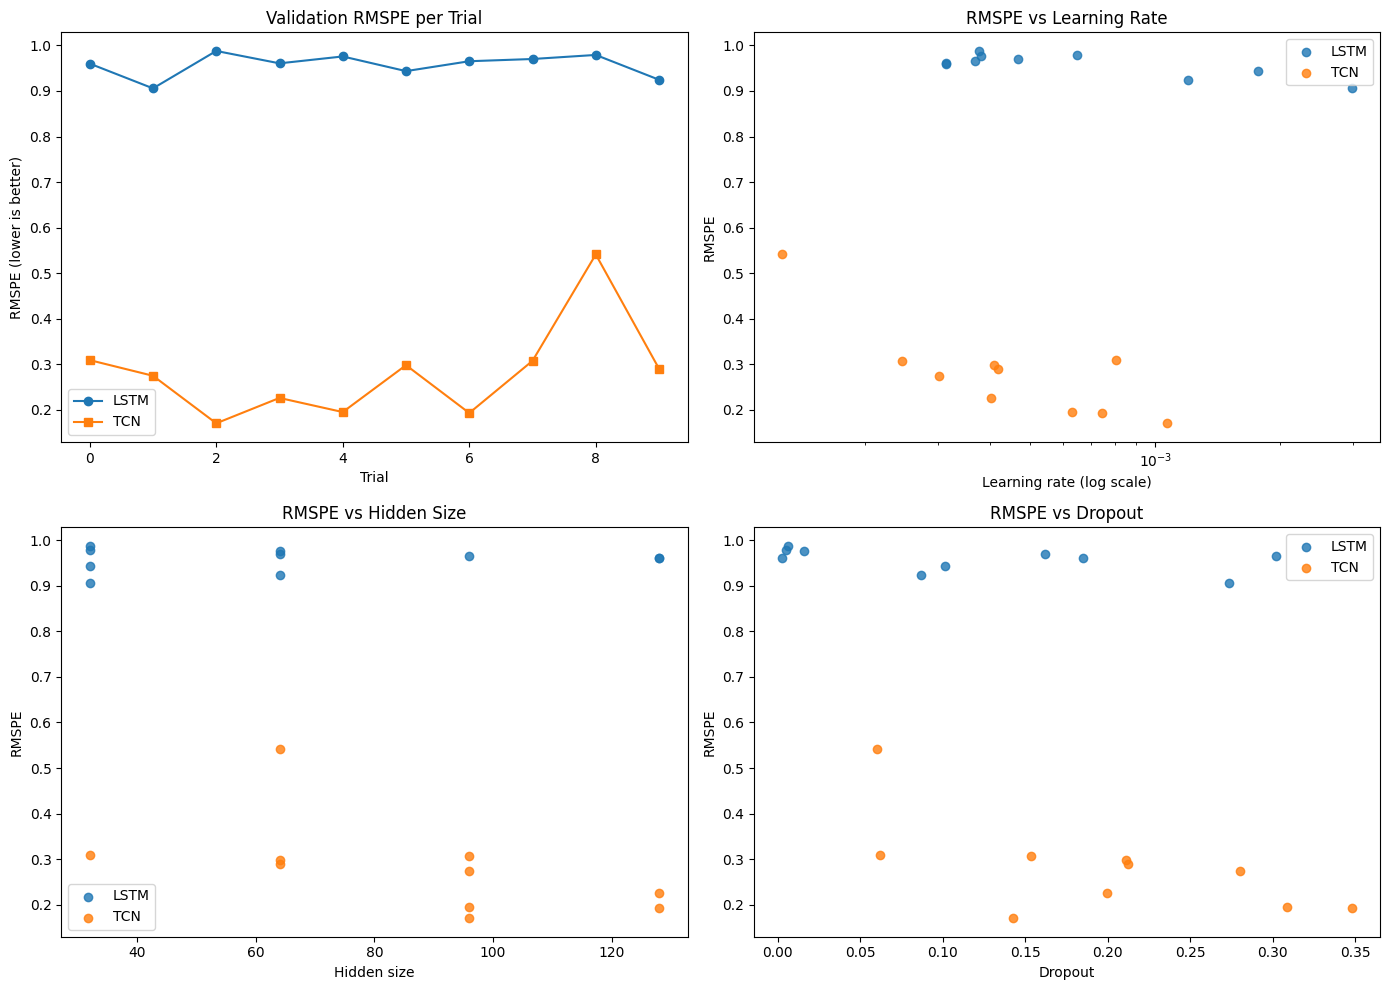

In [28]:
# Build trial tables for both studies
lstm_trials = study_lstm.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
tcn_trials = study_tcn.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

# Keep only completed trials
lstm_trials = lstm_trials[lstm_trials['state'] == 'COMPLETE'].copy()
tcn_trials = tcn_trials[tcn_trials['state'] == 'COMPLETE'].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Objective progression
axes[0, 0].plot(lstm_trials['number'], lstm_trials['value'], marker='o', label='LSTM')
axes[0, 0].plot(tcn_trials['number'], tcn_trials['value'], marker='s', label='TCN')
axes[0, 0].set_title('Validation RMSPE per Trial')
axes[0, 0].set_xlabel('Trial')
axes[0, 0].set_ylabel('RMSPE (lower is better)')
axes[0, 0].legend()

# 2) Learning rate sensitivity
if 'params_lr' in lstm_trials.columns and 'params_lr' in tcn_trials.columns:
    axes[0, 1].scatter(lstm_trials['params_lr'], lstm_trials['value'], alpha=0.8, label='LSTM')
    axes[0, 1].scatter(tcn_trials['params_lr'], tcn_trials['value'], alpha=0.8, label='TCN')
    axes[0, 1].set_xscale('log')
axes[0, 1].set_title('RMSPE vs Learning Rate')
axes[0, 1].set_xlabel('Learning rate (log scale)')
axes[0, 1].set_ylabel('RMSPE')
axes[0, 1].legend()

# 3) Hidden size sensitivity
if 'params_hidden_size' in lstm_trials.columns and 'params_hidden_size' in tcn_trials.columns:
    axes[1, 0].scatter(lstm_trials['params_hidden_size'], lstm_trials['value'], alpha=0.8, label='LSTM')
    axes[1, 0].scatter(tcn_trials['params_hidden_size'], tcn_trials['value'], alpha=0.8, label='TCN')
axes[1, 0].set_title('RMSPE vs Hidden Size')
axes[1, 0].set_xlabel('Hidden size')
axes[1, 0].set_ylabel('RMSPE')
axes[1, 0].legend()

# 4) Dropout sensitivity
if 'params_dropout' in lstm_trials.columns and 'params_dropout' in tcn_trials.columns:
    axes[1, 1].scatter(lstm_trials['params_dropout'], lstm_trials['value'], alpha=0.8, label='LSTM')
    axes[1, 1].scatter(tcn_trials['params_dropout'], tcn_trials['value'], alpha=0.8, label='TCN')
axes[1, 1].set_title('RMSPE vs Dropout')
axes[1, 1].set_xlabel('Dropout')
axes[1, 1].set_ylabel('RMSPE')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 9) Final Model Training and Evaluation

What we are doing is training both models with their best tuned parameters using the full training schedule.

We evaluate on validation and test sets and compare:
- point errors,
- RMSPE,
- uncertainty calibration,
- horizon-wise degradation.

In [29]:
# Final LSTM
p_lstm = study_lstm.best_params
final_lstm = LSTMQuantile(
    input_size=input_size,
    hidden_size=p_lstm['hidden_size'],
    num_layers=p_lstm.get('lstm_layers', 2),
    dropout=p_lstm['dropout'],
    horizon=CFG.horizon,
    n_quantiles=n_quant,
).to(DEVICE)

hist_lstm, _ = fit_model(final_lstm, train_loader, val_loader, epochs=CFG.epochs, lr=p_lstm['lr'])
val_metrics_lstm, y_val_lstm, p50_val_lstm, q10_val_lstm, q90_val_lstm = run_epoch(final_lstm, val_loader, optimizer=None)
test_metrics_lstm, y_test_lstm, p50_test_lstm, q10_test_lstm, q90_test_lstm = run_epoch(final_lstm, test_loader, optimizer=None)

# Final TCN
p_tcn = study_tcn.best_params
final_tcn = TCNQuantile(
    input_size=input_size,
    hidden_size=p_tcn['hidden_size'],
    horizon=CFG.horizon,
    n_quantiles=n_quant,
    dropout=p_tcn['dropout'],
).to(DEVICE)

hist_tcn, _ = fit_model(final_tcn, train_loader, val_loader, epochs=CFG.epochs, lr=p_tcn['lr'])
val_metrics_tcn, y_val_tcn, p50_val_tcn, q10_val_tcn, q90_val_tcn = run_epoch(final_tcn, val_loader, optimizer=None)
test_metrics_tcn, y_test_tcn, p50_test_tcn, q10_test_tcn, q90_test_tcn = run_epoch(final_tcn, test_loader, optimizer=None)

summary = pd.DataFrame([
    {'Model': 'LSTM', 'Split': 'Validation', **val_metrics_lstm},
    {'Model': 'LSTM', 'Split': 'Test', **test_metrics_lstm},
    {'Model': 'TCN', 'Split': 'Validation', **val_metrics_tcn},
    {'Model': 'TCN', 'Split': 'Test', **test_metrics_tcn},
])
summary

Epoch 01 | lr=0.002971 | train(eval) RMSPE=0.9520 | val RMSPE=0.9525 | val RMSE=6725.02 | val coverage=0.098
Epoch 02 | lr=0.002971 | train(eval) RMSPE=0.9045 | val RMSPE=0.9056 | val RMSE=6497.16 | val coverage=0.051
Epoch 03 | lr=0.002971 | train(eval) RMSPE=0.8578 | val RMSPE=0.8597 | val RMSE=6274.28 | val coverage=0.051
Epoch 04 | lr=0.002971 | train(eval) RMSPE=0.8118 | val RMSPE=0.8146 | val RMSE=6057.12 | val coverage=0.101
Epoch 05 | lr=0.002971 | train(eval) RMSPE=0.7666 | val RMSPE=0.7706 | val RMSE=5845.24 | val coverage=0.028
Epoch 06 | lr=0.002971 | train(eval) RMSPE=0.7226 | val RMSPE=0.7279 | val RMSE=5640.49 | val coverage=0.077
Epoch 07 | lr=0.002971 | train(eval) RMSPE=0.6796 | val RMSPE=0.6865 | val RMSE=5442.16 | val coverage=0.103
Epoch 08 | lr=0.002971 | train(eval) RMSPE=0.6382 | val RMSPE=0.6471 | val RMSE=5252.82 | val coverage=0.060
Epoch 09 | lr=0.002971 | train(eval) RMSPE=0.5986 | val RMSPE=0.6097 | val RMSE=5072.61 | val coverage=0.141
Epoch 10 | lr=0.002

/Users/moparo/u/mlproject/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 01 | lr=0.001068 | train(eval) RMSPE=0.3270 | val RMSPE=0.3456 | val RMSE=3528.48 | val coverage=0.580
Epoch 02 | lr=0.001068 | train(eval) RMSPE=0.2675 | val RMSPE=0.2970 | val RMSE=2602.83 | val coverage=0.789
Epoch 03 | lr=0.001068 | train(eval) RMSPE=0.1737 | val RMSPE=0.2016 | val RMSE=1546.45 | val coverage=0.760
Epoch 04 | lr=0.001068 | train(eval) RMSPE=0.1544 | val RMSPE=0.1859 | val RMSE=1462.07 | val coverage=0.767
Epoch 05 | lr=0.001068 | train(eval) RMSPE=0.1433 | val RMSPE=0.1750 | val RMSE=1344.01 | val coverage=0.787
Epoch 06 | lr=0.001068 | train(eval) RMSPE=0.1376 | val RMSPE=0.1730 | val RMSE=1368.90 | val coverage=0.769
Epoch 07 | lr=0.001068 | train(eval) RMSPE=0.1436 | val RMSPE=0.1783 | val RMSE=1383.13 | val coverage=0.771
Epoch 08 | lr=0.001068 | train(eval) RMSPE=0.1332 | val RMSPE=0.1695 | val RMSE=1223.64 | val coverage=0.751
Epoch 09 | lr=0.001068 | train(eval) RMSPE=0.1394 | val RMSPE=0.1737 | val RMSE=1301.53 | val coverage=0.763
Epoch 10 | lr=0.001

,Model,Split,RMSE,MAE,MAPE_pos,WMAPE,SMAPE,RMSPE,R2,Coverage_q10_q90,MeanIntervalWidth,Loss,RMSE_per_horizon
0,LSTM,Validation,4199.055846,3257.206787,0.372714,0.562526,0.744369,0.433404,-0.185438,0.230904,4420.736816,1637.155566,"[4146.498522850334, 4144.167950264564, 4146.44..."
1,LSTM,Test,4416.904119,3449.673828,0.400341,0.578748,0.775555,0.459315,-0.286644,0.219655,4335.613770,1735.280847,"[4392.768375409748, 4390.426858518429, 4434.07..."
2,TCN,Validation,1223.640674,673.168640,0.103317,0.116257,0.205360,0.169506,0.899334,0.751480,1661.021973,308.892119,"[1326.1037384005822, 1326.7162469797377, 1257...."
3,TCN,Test,2120.780281,1381.439697,0.179391,0.231763,0.398455,0.249345,0.703371,0.537370,2102.548096,624.881555,"[2088.651239436589, 2047.938841860274, 2165.24..."


### Analysis: Final Model Metrics

- **TCN clearly outperforms LSTM** on both validation and test across RMSE, MAE, and RMSPE.
- TCN also shows much stronger explanatory fit (`R2`) and better uncertainty interval behavior (higher `Coverage_q10_q90` with narrower `MeanIntervalWidth`).

## 9.5) Training Curves (Train vs Validation)

What we are doing in the next cell is plotting optimization history for both models.

These curves are essential for diagnosing:
- underfitting,
- overfitting,
- unstable optimization.

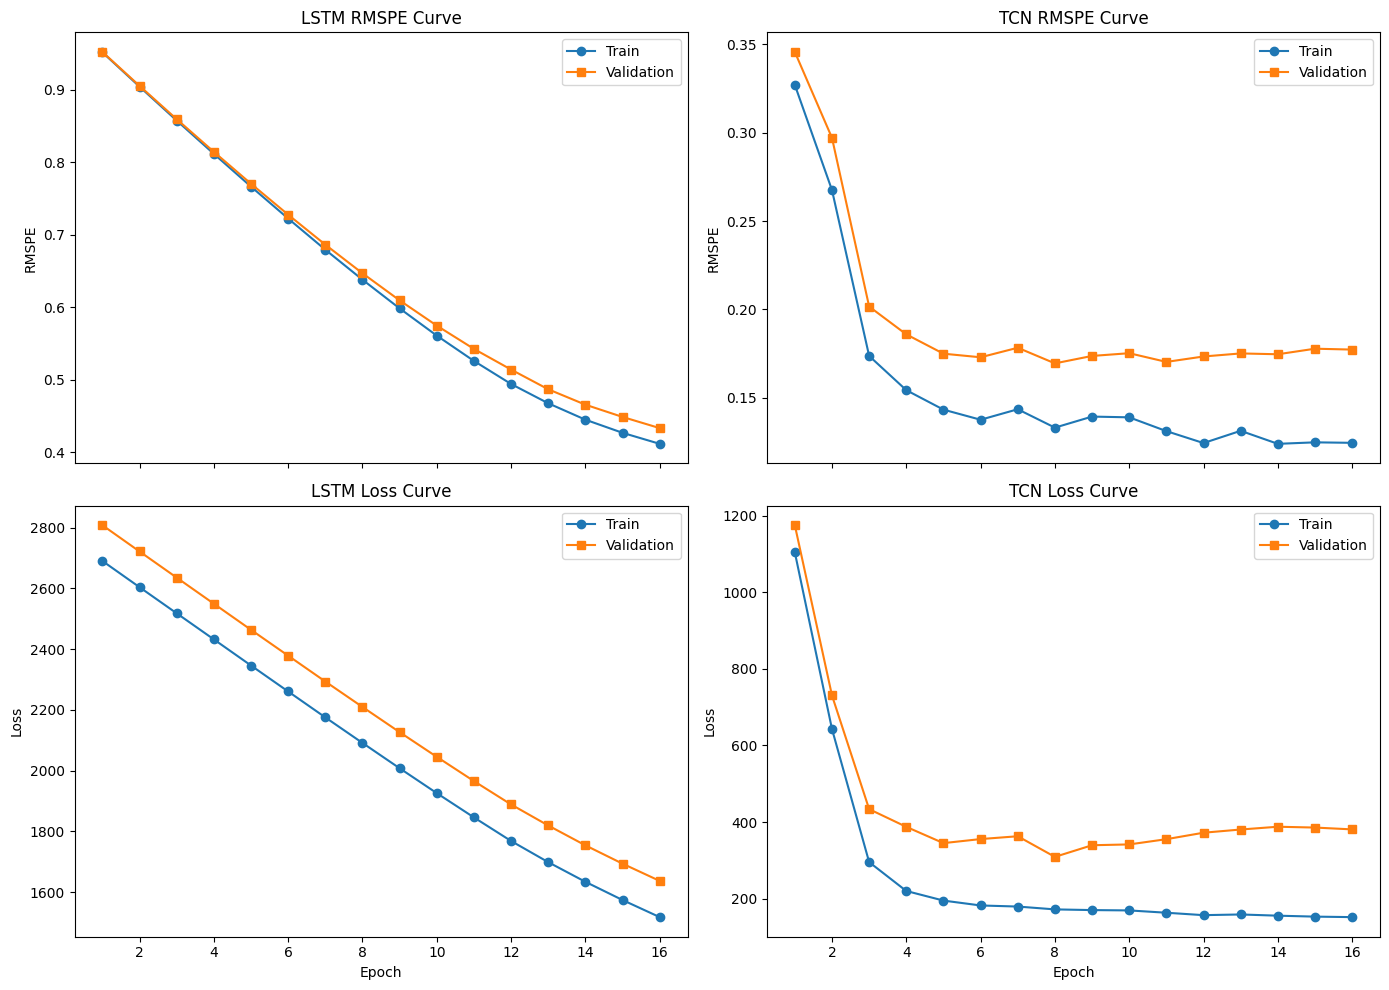

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# LSTM RMSPE
axes[0, 0].plot(hist_lstm['epoch'], hist_lstm['train_RMSPE'], marker='o', label='Train')
axes[0, 0].plot(hist_lstm['epoch'], hist_lstm['val_RMSPE'], marker='s', label='Validation')
axes[0, 0].set_title('LSTM RMSPE Curve')
axes[0, 0].set_ylabel('RMSPE')
axes[0, 0].legend()

# TCN RMSPE
axes[0, 1].plot(hist_tcn['epoch'], hist_tcn['train_RMSPE'], marker='o', label='Train')
axes[0, 1].plot(hist_tcn['epoch'], hist_tcn['val_RMSPE'], marker='s', label='Validation')
axes[0, 1].set_title('TCN RMSPE Curve')
axes[0, 1].set_ylabel('RMSPE')
axes[0, 1].legend()

# LSTM loss
axes[1, 0].plot(hist_lstm['epoch'], hist_lstm['train_Loss'], marker='o', label='Train')
axes[1, 0].plot(hist_lstm['epoch'], hist_lstm['val_Loss'], marker='s', label='Validation')
axes[1, 0].set_title('LSTM Loss Curve')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# TCN loss
axes[1, 1].plot(hist_tcn['epoch'], hist_tcn['train_Loss'], marker='o', label='Train')
axes[1, 1].plot(hist_tcn['epoch'], hist_tcn['val_Loss'], marker='s', label='Validation')
axes[1, 1].set_title('TCN Loss Curve')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Analysis: Training Curves and the Train-vs-Validation Question

- We now compute the train curve in evaluation mode on a deterministic, non-shuffled train-eval loader, so train and validation are directly comparable.
- In this run, LSTM shows smooth monotonic improvement; TCN is stable with moderate fluctuation but no optimization divergence.

## 9.1) Understanding Model Differences

What we are doing in this interpretation section is diagnosing why one model may outperform another.

Possible causes include:
- architecture bias,
- optimization sensitivity,
- feature interactions,


## 10) Horizon-Wise Error Analysis

What we are doing is plotting error by forecast step (t+1 to t+7).

This tells us whether a model degrades smoothly with horizon or fails abruptly at longer steps.

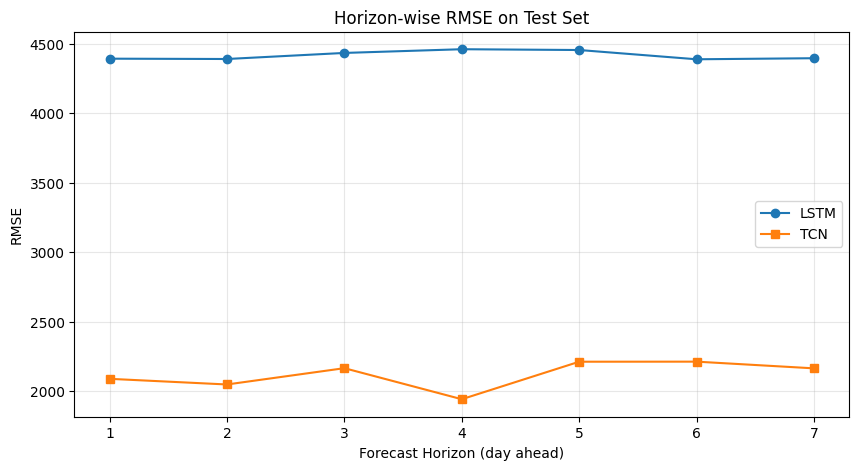

In [31]:
h = np.arange(1, CFG.horizon + 1)
plt.figure(figsize=(10, 5))
plt.plot(h, test_metrics_lstm['RMSE_per_horizon'], marker='o', label='LSTM')
plt.plot(h, test_metrics_tcn['RMSE_per_horizon'], marker='s', label='TCN')
plt.xlabel('Forecast Horizon (day ahead)')
plt.ylabel('RMSE')
plt.title('Horizon-wise RMSE on Test Set')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Analysis: Horizon-wise Test RMSE

- TCN is better than LSTM on RMSE at every horizon in this run, indicating stronger absolute-scale forecasting throughout t+1 to t+7.
- The TCN curve is relatively smooth, with mild mid-horizon variation but no abrupt degradation pattern.
- LSTM stays consistently higher across all horizons, so there is no horizon where it overtakes TCN in this run.
- Combined with the RMSPE summary, this supports TCN as the stronger overall model for the current configuration.

## 11) SHAP-Based Interpretation (Surrogate Approach)

What we are doing is approximating deep-model feature importance with a surrogate tree model and SHAP.

/var/folders/ny/hj1yhkt95pzgbdwnxvn669k80000gn/T/ipykernel_99657/3270016624.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sur, feature_names=candidate_features, plot_type='bar', show=False)


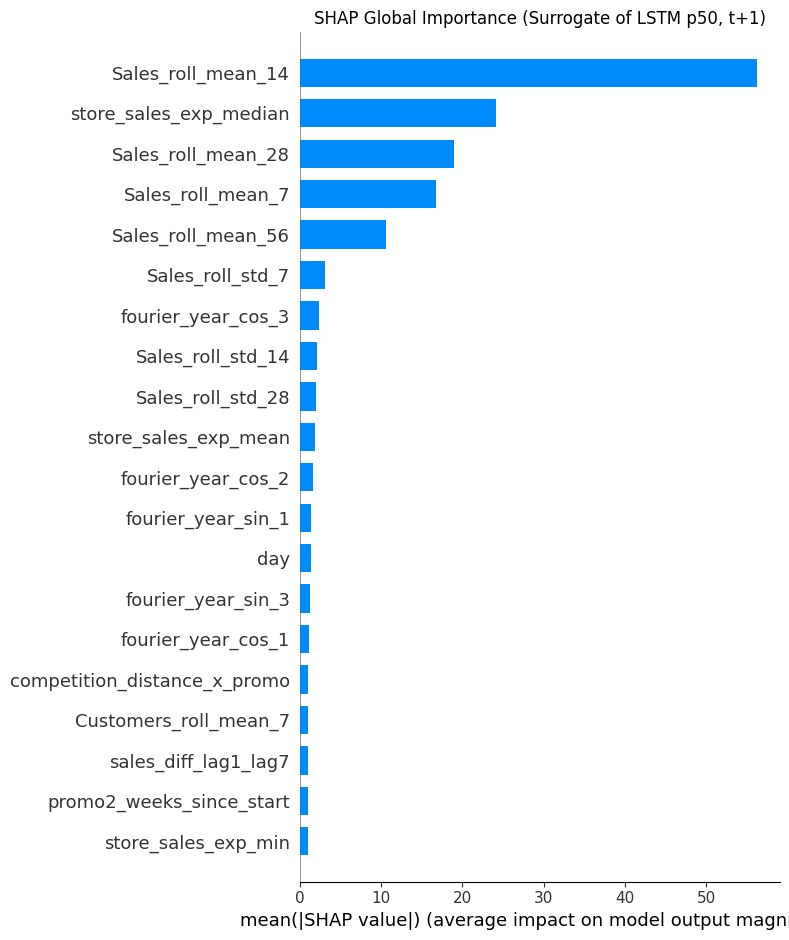

In [32]:
# Build tabular surrogate dataset from last timestep in each sequence
X_val_seq = val_ds.X
X_val_last = X_val_seq[:, -1, :]
y_val_pred_day1 = p50_val_lstm[:, 0]  # model-driven target for interpretability

# Sample to keep SHAP runtime stable
n_sample = min(3000, len(X_val_last))
idx = np.random.choice(len(X_val_last), n_sample, replace=False)
X_sur = X_val_last[idx]
y_sur = y_val_pred_day1[idx]

surrogate = RandomForestRegressor(n_estimators=150, random_state=SEED, n_jobs=-1)
surrogate.fit(X_sur, y_sur)

explainer = shap.TreeExplainer(surrogate)
shap_values = explainer.shap_values(X_sur)

# SHAP summary (bar)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sur, feature_names=candidate_features, plot_type='bar', show=False)
plt.title('SHAP Global Importance (Surrogate of LSTM p50, t+1)')
plt.tight_layout()
plt.show()

### Analysis: SHAP Interpretability

- SHAP importance is dominated by lag/rolling sales dynamics and calendar periodicity, which is a sensible retail signal pattern.

## 12) Save All Artifacts

What we are doing is exporting metrics, histories, predictions, and a JSON report.

This ensures the run is auditable, comparable, and reproducible across future iterations.

In [33]:
out_dir = Path('../data/phase5_output')
out_dir.mkdir(parents=True, exist_ok=True)

# Save summary tables
summary.to_csv(out_dir / 'metrics_summary.csv', index=False)
hist_lstm.to_csv(out_dir / 'history_lstm.csv', index=False)
hist_tcn.to_csv(out_dir / 'history_tcn.csv', index=False)

# Save params and metrics in JSON
report = {
    'device': str(DEVICE),
    'config': CFG.__dict__,
    'best_params_lstm': study_lstm.best_params,
    'best_params_tcn': study_tcn.best_params,
    'val_metrics_lstm': val_metrics_lstm,
    'test_metrics_lstm': test_metrics_lstm,
    'val_metrics_tcn': val_metrics_tcn,
    'test_metrics_tcn': test_metrics_tcn
}

with open(out_dir / 'phase5_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

# Save test predictions (flattened by horizon)
pred_lstm_df = pd.DataFrame({
    'y_true_t1': y_test_lstm[:, 0],
    'p10_t1': q10_test_lstm[:, 0],
    'p50_t1': p50_test_lstm[:, 0],
    'p90_t1': q90_test_lstm[:, 0],
})
pred_tcn_df = pd.DataFrame({
    'y_true_t1': y_test_tcn[:, 0],
    'p10_t1': q10_test_tcn[:, 0],
    'p50_t1': p50_test_tcn[:, 0],
    'p90_t1': q90_test_tcn[:, 0],
})
pred_lstm_df.to_csv(out_dir / 'predictions_lstm_t1.csv', index=False)
pred_tcn_df.to_csv(out_dir / 'predictions_tcn_t1.csv', index=False)

print('Saved Phase-5 artifacts to:', out_dir.resolve())
for p in sorted(out_dir.glob('*')):
    print('-', p.name)

Saved Phase-5 artifacts to: /Users/moparo/u/mlproject/data/phase5_output
- history_lstm.csv
- history_tcn.csv
- metrics_summary.csv
- phase5_report.json
- predictions_lstm_t1.csv
- predictions_tcn_t1.csv


## 12.1) Competition-Style RMSPE Summary

What we are doing in the next cell is computing RMSPE in a competition-like way on test predictions.

We report both:
- flattened all-horizon RMSPE,
- one-step (t+1) RMSPE.

In [34]:
# Competition-style RMSPE comparison (ignoring zero-sales targets)
def rmspe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true > 0
    if mask.sum() == 0:
        return np.nan
    pct = (y_true[mask] - y_pred[mask]) / np.maximum(y_true[mask], eps)
    return float(np.sqrt(np.mean(pct ** 2)))

lstm_rmspe_all = rmspe(y_test_lstm.ravel(), p50_test_lstm.ravel())
tcn_rmspe_all = rmspe(y_test_tcn.ravel(), p50_test_tcn.ravel())

lstm_rmspe_t1 = rmspe(y_test_lstm[:, 0], p50_test_lstm[:, 0])
tcn_rmspe_t1 = rmspe(y_test_tcn[:, 0], p50_test_tcn[:, 0])

print('Competition-style RMSPE (test, all horizons):')
print(f'  LSTM: {lstm_rmspe_all:.5f}')
print(f'  TCN : {tcn_rmspe_all:.5f}')
print('Competition-style RMSPE (test, t+1 only):')
print(f'  LSTM: {lstm_rmspe_t1:.5f}')
print(f'  TCN : {tcn_rmspe_t1:.5f}')

Competition-style RMSPE (test, all horizons):
  LSTM: 0.45932
  TCN : 0.24935
Competition-style RMSPE (test, t+1 only):
  LSTM: 0.46083
  TCN : 0.22697


### Analysis: Competition-style RMSPE

- For all-horizon RMSPE on test, TCN is better.
- For one-step RMSPE (t+1), TCN is also better.